In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

labFS = 16
legFS = 12

# 1. Reading and Processing Data

In [2]:
def ReadMultiIndexParquet(filename):
    '''
    INPUT
    - filename: string. The name of the parquet file.
    
    OUTPUT
    - reset_data: PandasDataFrame.
    '''
    data = pd.read_parquet(filename)

    # Reset index and keep MultiIndex levels as columns
    reset_data = data.reset_index()

    # Create columns for each level of the MultiIndex
    for level_num in range(data.index.nlevels):
        level_name = data.index.names[level_num]
        reset_data[level_name] = data.index.get_level_values(level_num)

    return reset_data

In [3]:
def FreqMatrix(year):
    '''
    INPUT
    - year: int. Year of interest.
    
    OUTPUT: None
    
    But it will save the following csv
    
    - words_year: list.
    - counties_year: (counties_filtered): list. Returns the counties in the order that they are placed in the final matrix saved.
    - MatrixFreq_year: np.array(number_words x number_counties). It contains the frequency of each word (rows) in each county (columns).
    
    WARNING: The program is expect to last approximately 6h.
    '''
    
    path = r'C:\Users\nadal\Downloads\CommunityDetection\US_word_counts\US_word_counts'
    
    # From this parquet you get the counties and the frequencies of each word in each couny
    raw_cell_filename = path +r'\raw_cell_counts_lang=en_cc=US_years=%.d-%.d_cell_size=county.parquet'%(year,year)
    data = ReadMultiIndexParquet(raw_cell_filename)
    # From this parquet you get the different words and their total frequencies 
    region_counts_filename = path + r'\region_counts_lang=en_cc=US_years=%.d-%.d_cell_size=county.parquet'%(year,year)
    data_counts = ReadMultiIndexParquet(region_counts_filename)
    # Total frequencies
    total_counts = data_counts['count'].to_numpy()
    # Frequencies in each county
    freq_raw = data['count'].to_numpy()
    # Counties
    counties_raw = data['cell_id'].to_numpy()
    counties_raw = [int(x) for x in counties_raw]
    counties = np.asarray(sorted(list(set(counties_raw))))
    # Words
    words = data_counts['word'].to_numpy()
    words_raw = data['word'].to_numpy()
    
    # Getting the words to be erased in a list
    file = open("INTERJ_LIST.txt", "r")
    interj_list = file.read().splitlines()
    file.close()

    file = open("FUNCTION_LIST.txt", "r")
    function_list = file.read().splitlines()
    file.close()

    # Eliminating discarded words (list.remove() is better here since you don't need to find the index)
    words = list(words)
    total_counts = list(total_counts)
    for w in interj_list:
        index_w = words.index(w)
        words.remove(w)
        total_counts.pop(index_w)
    for w in function_list:
        index_w = words.index(w)
        words.remove(w)
        total_counts.pop(index_w)

    words = np.asarray(words)
    total_counts = np.asarray(total_counts)
    
    
    # With this parameter we select the N_max most frequent words to continue the analysis
    N_max = 10**4
    # List of the final words to be studied
    words_max = []
    for i in range(N_max):
        index_max = np.where(total_counts == np.max(total_counts))[0][0]
        words_max.append(words[index_max])
        # We erase this information in order to be able to find the next maximum without resizings that
        # will make us loose track of the position of the words in the respective arrays.
        total_counts[index_max] = 0
        
    # Constructing the matrix for the final selection of words and all the counties    
    n_words_max = len(words_max)
    n_counties = len(counties)
    matrix = np.zeros((n_words_max,n_counties))
    for i in range(n_words_max):
        indexes = np.where(words_raw==words_max[i])[0]
        for ind in indexes:
            # Index of the county
            j = np.where(counties == counties_raw[ind])[0]
            matrix[i,j] = freq_raw[ind]
            
    # The following lines were used to do a county filtering, but in the last versions of the code this process was done 
    # outside this function
    '''       
    # Now it remains to eliminate those counties that does not sum up 50.000 tokens
    # We first identify which ones are those with a total number of counts, for whichever word, lover than a threshold.
    threshold = 5*10**4
    total_tokens = np.zeros(n_counties)
    for j in range(n_counties):
        total_tokens[j] = np.sum(matrix[:,j])

    pos_erase = []   
    for j in range(n_counties):
        if total_tokens[j]<threshold:
            pos_erase.append(j)
     '''       
    # Then, one should eliminate these elements from the counties array and from the matrix.
    counties_filtered = list(counties)
    '''
    matrix = np.delete(matrix,pos_erase, axis = 1)
    for ind in pos_erase:
        counties_filtered.remove(counties[ind])
    '''
        
    # Saving the data in a csv    
    df_matrix_freq = pd.DataFrame(matrix)
    df_matrix_freq.to_csv('MatrixFreq_%.d.csv'%year, index = False)
    
    df_c = pd.DataFrame(counties_filtered)
    df_c.to_csv('counties_%.d.csv'%year,index = False)
    
    df_w = pd.DataFrame(words_max)
    df_w.to_csv('words_%.d.csv'%year,index = False)

In [4]:
def TotCountsCounty(read_counties, year):
    '''
    INPUT
    - read_counties: list. Counties in the order that appears in the final matrix saved.
    - year: int. Year of interest.
    
    OUTPUT
    - tot_count: array. Total counts for each county (summing up the frequencies of all the words)
    '''
    
    path = r'C:\Users\nadal\Downloads\CommunityDetection\US_word_counts\US_word_counts'
    
    tot_count = np.zeros(len(read_counties))
    
    # Reading the data
    raw_cell_filename = path +r'\raw_cell_counts_lang=en_cc=US_years=%.d-%.d_cell_size=county.parquet'%(year,year)
    data = ReadMultiIndexParquet(raw_cell_filename)
    
    # cell_id count
    cell_id = data['cell_id'].to_numpy()
    count = data['count'].to_numpy()
    
    for i in range(len(read_counties)):
        print(i)
        indexes = np.where(cell_id == read_counties[i])[0]
        tot_count[i] = np.sum(count[indexes])
        
    return tot_count

In [30]:
# Examples of the parquet files used
year = 2020
path = r'C:\Users\nadal\Downloads\CommunityDetection\US_word_counts\US_word_counts'
    
# From this parquet you get the counties and the frequencies of each word in each couny
raw_cell_filename = path +r'\raw_cell_counts_lang=en_cc=US_years=%.d-%.d_cell_size=county.parquet'%(year,year)
data = ReadMultiIndexParquet(raw_cell_filename)
print(data)
# From this parquet you get the different words and their total frequencies 
region_counts_filename = path + r'\region_counts_lang=en_cc=US_years=%.d-%.d_cell_size=county.parquet'%(year,year)
data_counts = ReadMultiIndexParquet(region_counts_filename)
print(data_counts)

         word  cell_id         count
0           a   1001.0   4991.805404
1           a   1003.0  25214.667419
2           a   1005.0    828.954684
3           a   1007.0    456.486884
4           a   1009.0    943.000000
...       ...      ...           ...
67406397    𝞹  48187.0      0.000240
67406398    𝞹  48493.0      0.015132
67406399    𠂆  25017.0      0.183817
67406400    𠂆  25021.0      0.322203
67406401    𠂆  25025.0      0.493980

[67406402 rows x 3 columns]
          word       count  count_upper      nr_cells  is_proper
0            a  65829961.0    3452327.0  35311.191151      False
1           aa     20070.0      18802.0   4382.777338      False
2          aaa      8985.0       8032.0   2901.002704      False
3         aaaa      1129.0        825.0    630.409263      False
4        aaaaa       700.0        524.0    406.066047      False
...        ...         ...          ...           ...        ...
3079156      𝝳         1.0          0.0      1.000000      False
3079157

In [5]:
# Creating the frequency matrix
year = 2020
FreqMatrix(year)

In [105]:
# Reading saved files
year = 2017
matrix_freq = pd.read_csv('MatrixFreq_%.d.csv'%year).to_numpy()
read_words = pd.read_csv('words_%.d.csv'%year).to_numpy().tolist()
read_counties = pd.read_csv('counties_%.d.csv'%year).to_numpy().tolist()
matrix_freq_rel = pd.read_csv('matrix_freq_rel%.d.csv'%year).to_numpy()

In [107]:
# Creating the relative frequency matrix
tot_counts_county = TotCountsCounty(read_counties, year)

matrix_freq_rel = np.zeros((np.size(matrix_freq,0), np.size(matrix_freq,1)))
for i in range(np.size(matrix_freq,1)): # Loop for counties
    matrix_freq_rel[:,i] = matrix_freq[:,i]/tot_counts_county[i]
    
# Saving it
df = pd.DataFrame(matrix_freq_rel)
df.to_csv('matrix_freq_rel%.d.csv'%year, index=False, header=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [108]:
# Filtering of counties that does not surpass some minimal threshold of total counts
threshold = 3*10**3

pos_erase = []   
for j in range(len(read_counties)):
    if tot_counts_county[j]<threshold:
        pos_erase.append(j) 
        
counties_filtered = list(read_counties)
matrix_filtered = np.delete(matrix_freq_rel,pos_erase, axis = 1)
for ind in pos_erase:
    counties_filtered.remove(read_counties[ind])

In [109]:
# Matching FIPS codes for counties
# In the parquet files used, when a county identifier began by '0' it was erased. But in the data used for the shape of the
# counties it was present. In order to match the two strings, the following lines add that '0' when erased.
read_counties = pd.read_csv('counties_%.d.csv'%year).to_numpy().tolist()
counties = []
for i in read_counties:
    aux = str(i[0])
    if len(aux)!=5:
        aux = '0'+aux
    counties.append(aux)

# __2. PCA and Clustering__

0
1
2
3
4
5
6
7
8


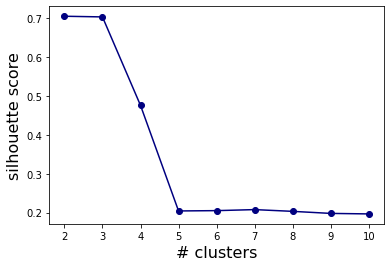

In [60]:
# Perform PCA on the dataset
read = matrix_filtered.transpose()
pca = PCA()
X_pca = pca.fit_transform(read)

# Determining the optimal number of clusters to fins using the silhouette score
from sklearn.metrics import silhouette_score

num_clust = [i for i in range(2,11)]
silhouette_avg = np.zeros(len(num_clust))
for i in range(len(num_clust)):
    print(i)
    hierarchical = AgglomerativeClustering(n_clusters=num_clust[i], linkage='ward')
    hierarchical_labels = hierarchical.fit_predict(X_pca)
    silhouette_avg[i] = silhouette_score(X_pca, hierarchical_labels)

plt.plot(num_clust, silhouette_avg, color = 'navy', marker = 'o')
plt.xlabel(r'# clusters', fontsize = labFS)
plt.ylabel(r'silhouette score', fontsize = labFS)
plt.savefig('Silhouette score_%.d.pdf'%year)

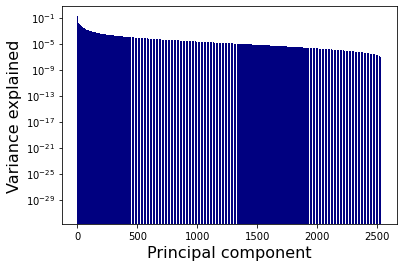

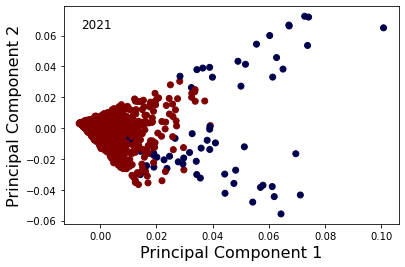

In [101]:
# Variance explained by each principal component
variance_ratio = pca.explained_variance_ratio_
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, color = 'navy')
plt.xlabel(r'Principal component', fontsize = labFS)
plt.ylabel(r'Variance explained', fontsize = labFS)
plt.yscale('log')
plt.savefig('VarExplained_%.d.pdf'%year)
plt.show()

# Perform hierarchical clustering for the optimal value of clusters found
hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_pca)

# Projection in the first 2 PC + clustering labels
fig, ax = plt.subplots()

textbox = r'%.d'% year
ax.text(0.05 , 0.90,textbox, transform=ax.transAxes, fontsize=legFS)

plt.scatter(X_pca[:,0], X_pca[:,1], c=hierarchical_labels, cmap='seismic')
plt.xlabel(r'Principal Component 1', fontsize = labFS)
plt.ylabel(r'Principal Component 2', fontsize = labFS)
plt.savefig('PC_projection_%.d.pdf'%year)
plt.show()

# __3. Plotting with Geopandas__

In [14]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

In [15]:
# Reading from the shapefile file the limits of the counties
tl_2023_us_county = gpd.read_file(r'tl_2023_us_county\tl_2023_us_county.shp')
# In order to see the cell_id as we have it for each county
tl_2023_us_county['cell_id'] = tl_2023_us_county['STATEFP'] + tl_2023_us_county['COUNTYFP']
tl_2023_us_county.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cell_id
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",31039
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2...",53069
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0...",35011
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523...",31109
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122...",31129


In [48]:
# Preparing the DataFrame for the relative frequency plots
word_of_interest = ['traffic']
read_words = list(read_words)
index_w = read_words.index(word_of_interest)

N = np.zeros(len(counties))
for i in range(len(counties)):
    N[i] = np.sum(matrix_freq[:,i])
    
df = pd.DataFrame(data={'cell_id': counties, 'freq': matrix_freq_rel[index_w,:]})
df

,cell_id,freq
0,01001,0.000028
1,01003,0.000040
2,01005,0.000000
3,01007,0.000000
4,01009,0.000104
...,...,...
3103,56037,0.000007
3104,56039,0.000033
3105,56041,0.000051
3106,56043,0.000000


In [111]:
# Preparing the DataFrames for the plots with labels
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_pca)

counties_str = []
for i in counties_filtered:
    aux = str(i[0])
    if len(aux)!=5:
        aux = '0'+aux
    counties_str.append(aux)

df = pd.DataFrame(data={'cell_id': counties_str, 'label': hierarchical_labels})
df

,cell_id,label
0,01001,0
1,01003,0
2,01005,0
3,01007,0
4,01009,0
...,...,...
2759,56037,0
2760,56039,0
2761,56041,0
2762,56043,0


In [112]:
merged_data = pd.merge(tl_2023_us_county, df, on='cell_id', how='left')
merged_data.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cell_id,label
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,...,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",31039,0.0
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,...,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2...",53069,NaN
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,...,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0...",35011,NaN
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,...,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523...",31109,0.0
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,...,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122...",31129,NaN


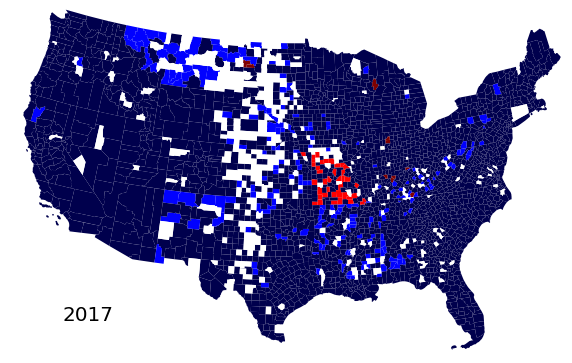

In [113]:
# Simplify the geometries
simplified_geoms = merged_data.simplify(tolerance=0.01, preserve_topology=True).geometry

# Create a new GeoDataFrame with simplified geometries
simplified_gdf = gpd.GeoDataFrame(geometry=simplified_geoms, crs=merged_data.crs)
# simplified_gdf['freq'] = merged_data['freq']
simplified_gdf['label'] = merged_data['label']

'''
from matplotlib.colors import ListedColormap
# Define el colormap original (por ejemplo, Reds)
original_colormap = plt.get_cmap('Reds')
# Especifica la fracción de colores que deseas usar (por ejemplo, del 0.2 al 1.0)
fraction = 0.2
# Calcula el índice donde comienza la fracción que deseas
start_index = int(original_colormap.N * fraction)
# Crea un rango de valores desde start_index hasta el final
new_colors = original_colormap(np.linspace(start_index / original_colormap.N, 1.0, original_colormap.N - start_index))
# Crea un nuevo colormap personalizado
new_colormap = ListedColormap(new_colors)
'''


# Plot the simplified GeoDataFrame
ax = simplified_gdf.to_crs(epsg=5071).plot(figsize=(10, 10), column='label', cmap='seismic', edgecolor='white', linewidth=0, missing_kwds={'color': 'white'})

textbox = r'%.d'% year
ax.text(0.1 , 0.1,textbox, transform=ax.transAxes, fontsize=labFS+4)

'''
# Add a colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.5)
cbar.set_label('Relative frequency for "traffic"', fontsize = labFS+4)
#cbar.set_label('Fourth Principal Component', fontsize = labFS+4)
'''


ax.axis('off')

ax.set_xlim([-2.5*10**6, 2.3*10**6])
ax.set_ylim([0.2*10**6, 3.2*10**6])

plt.savefig('Communities_%.d_5.pdf'%year, bbox_inches = 'tight')

In [ ]:
# Tengo a los ángeles como overrepresented. No sé lo que pasa con eso. Esto viene por tener una población grande que haga que tengas
# frecuencias más altas. Un problema que no hemos podido corregir del todo.

In [ ]:
# Youtube videos on geopandas
# https://www.youtube.com/watch?v=1vvW8RwwT6o&list=PLewNEVDy7gq3DjrPDxGFLbHE4G2QWe8Qh&index=14

# Here's were I got the shp for the counties.
# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html